In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
zip_path = '/content/drive/MyDrive/cmfd(localzn).zip'
extract_path = '/content/cmfd_dataset'

In [3]:
import zipfile, os
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
print(" Dataset extracted to:", extract_path)

 Dataset extracted to: /content/cmfd_dataset


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
import tensorflow as tf
import os, cv2, numpy as np
from tensorflow.keras.utils import Sequence

IMG_SIZE = 224
BATCH_SIZE = 8
dataset_path = '/content/cmfd_dataset/cmfd(localzn)'

def get_image_pairs(dataset_path):
    files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    pairs = []
    for file in files:
        if "_F" in file:
            base = file.split("_F")[0]
            mask_candidates = [f for f in files if f.startswith(base) and ("_B" in f or "_M" in f or "mask" in f.lower())]
            if mask_candidates:
                pairs.append((os.path.join(dataset_path, file),
                              os.path.join(dataset_path, mask_candidates[0])))
    print(f"Total paired samples found: {len(pairs)}")
    return pairs

pairs = get_image_pairs(dataset_path)

split_idx = int(0.8 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]

class CMFDGenerator(Sequence):
    def __init__(self, pairs, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
        self.pairs = pairs
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.pairs)

    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = [], []
        for img_path, mask_path in batch_pairs:
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is None or mask is None:
                continue
            img = cv2.resize(img, (self.img_size, self.img_size)).astype(np.float32)/255.0
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            mask = (mask>127).astype(np.float32)
            X.append(img)
            y.append(np.expand_dims(mask, -1))
        return np.array(X), np.array(y)

train_gen = CMFDGenerator(train_pairs, batch_size=8)
val_gen   = CMFDGenerator(val_pairs, batch_size=8, shuffle=False)


Total paired samples found: 5000


In [6]:
from sklearn.model_selection import train_test_split

train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42, shuffle=True)

train_gen = CMFDGenerator(train_pairs, batch_size=8)
val_gen   = CMFDGenerator(val_pairs, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_pairs)} | Val samples: {len(val_pairs)}")


Train samples: 4000 | Val samples: 1000


In [7]:
def transformer_block(x, num_heads=4, key_dim=64, ff_dim=256):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ff = tf.keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dense(x.shape[-1])
    ])
    x2 = ff(x)
    x = layers.Add()([x, x2])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_resnet50_vit_unet(input_shape=(224,224,3), patch_size=16):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    skips = [
        base.get_layer("conv1_relu").output,
        base.get_layer("conv2_block3_out").output,
        base.get_layer("conv3_block4_out").output,
        base.get_layer("conv4_block6_out").output,
    ]
    x = base.output
    B, H, W, C = x.shape
    n_patches = (H*W)
    x = layers.Reshape((n_patches, C))(x)
    x = transformer_block(x, num_heads=8, key_dim=64, ff_dim=512)
    x = layers.Reshape((H,W,C))(x)

    def up_block(x, skip, f):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        return x

    x = up_block(x, skips[-1], 512)
    x = up_block(x, skips[-2], 256)
    x = up_block(x, skips[-3], 128)
    x = up_block(x, skips[-4], 64)
    x = layers.UpSampling2D((2,2))(x)
    out = layers.Conv2D(1, 1, activation="sigmoid")(x)

    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_resnet50_vit_unet((IMG_SIZE,IMG_SIZE,3))
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 50,244,417 (191.67 MB)

 Trainable params: 50,191,297 (191.46 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1 - dice_coef(y_true, y_pred))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_metric, tf.keras.metrics.BinaryAccuracy()])

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('best_resnet50_vit_unet.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - binary_accuracy: 0.7506 - dice_coef: 0.6663 - iou_metric: 0.5082 - loss: 0.8499

500/500 ━━━━━━━━━━━━━━━━━━━━ 243s 311ms/step - binary_accuracy: 0.7507 - dice_coef: 0.6664 - iou_metric: 0.5082 - loss: 0.8498 - val_binary_accuracy: 0.4956 - val_dice_coef: 0.5843 - val_iou_metric: 0.4189 - val_loss: 1.4948 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.7862 - dice_coef: 0.7170 - iou_metric: 0.5657 - loss: 0.7388

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 287ms/step - binary_accuracy: 0.7862 - dice_coef: 0.7170 - iou_metric: 0.5656 - loss: 0.7388 - val_binary_accuracy: 0.7954 - val_dice_coef: 0.6776 - val_iou_metric: 0.5185 - val_loss: 0.7884 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.8037 - dice_coef: 0.7281 - iou_metric: 0.5788 - loss: 0.7032

500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 289ms/step - binary_accuracy: 0.8038 - dice_coef: 0.7281 - iou_metric: 0.5788 - loss: 0.7032 - val_binary_accuracy: 0.8148 - val_dice_coef: 0.7325 - val_iou_metric: 0.5844 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.8275 - dice_coef: 0.7620 - iou_metric: 0.6212 - loss: 0.6267

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - binary_accuracy: 0.8275 - dice_coef: 0.7620 - iou_metric: 0.6213 - loss: 0.6267 - val_binary_accuracy: 0.8462 - val_dice_coef: 0.7649 - val_iou_metric: 0.6256 - val_loss: 0.5780 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 277ms/step - binary_accuracy: 0.8487 - dice_coef: 0.7855 - iou_metric: 0.6531 - loss: 0.5659 - val_binary_accuracy: 0.8378 - val_dice_coef: 0.7931 - val_iou_metric: 0.6638 - val_loss: 0.5930 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.8486 - dice_coef: 0.7875 - iou_metric: 0.6563 - loss: 0.5586

500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 293ms/step - binary_accuracy: 0.8486 - dice_coef: 0.7875 - iou_metric: 0.6563 - loss: 0.5586 - val_binary_accuracy: 0.8525 - val_dice_coef: 0.7976 - val_iou_metric: 0.6697 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.8587 - dice_coef: 0.8043 - iou_metric: 0.6790 - loss: 0.5248

500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 289ms/step - binary_accuracy: 0.8587 - dice_coef: 0.8043 - iou_metric: 0.6790 - loss: 0.5247 - val_binary_accuracy: 0.8663 - val_dice_coef: 0.8105 - val_iou_metric: 0.6874 - val_loss: 0.5084 - learning_rate: 1.0000e-04
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - binary_accuracy: 0.8651 - dice_coef: 0.8089 - iou_metric: 0.6840 - loss: 0.5063 - val_binary_accuracy: 0.8569 - val_dice_coef: 0.7996 - val_iou_metric: 0.6727 - val_loss: 0.5348 - learning_rate: 1.0000e-04
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - binary_accuracy: 0.8627 - dice_coef: 0.8069 - iou_metric: 0.6815 - loss: 0.5093 - val_binary_accuracy: 0.8552 - val_dice_coef: 0.8050 - val_iou_metric: 0.6794 - val_loss: 0.5109 - learning_rate: 1.0000e-04
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.8736 - dice_coef: 0.8224 - iou_metric: 0.7037 - loss: 0.4645 - val_binary_accuracy: 0.8602 - val_dice_coef: 0.7847 - val_iou_metric: 0.6515 -

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 286ms/step - binary_accuracy: 0.8818 - dice_coef: 0.8290 - iou_metric: 0.7138 - loss: 0.4373 - val_binary_accuracy: 0.8815 - val_dice_coef: 0.8194 - val_iou_metric: 0.6993 - val_loss: 0.4494 - learning_rate: 1.0000e-04
Epoch 12/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - binary_accuracy: 0.8831 - dice_coef: 0.8353 - iou_metric: 0.7216 - loss: 0.4323 - val_binary_accuracy: 0.8699 - val_dice_coef: 0.8257 - val_iou_metric: 0.7094 - val_loss: 0.5067 - learning_rate: 1.0000e-04
Epoch 13/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - binary_accuracy: 0.8711 - dice_coef: 0.8214 - iou_metric: 0.7016 - loss: 0.4750

500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 298ms/step - binary_accuracy: 0.8711 - dice_coef: 0.8214 - iou_metric: 0.7016 - loss: 0.4750 - val_binary_accuracy: 0.8877 - val_dice_coef: 0.8310 - val_iou_metric: 0.7157 - val_loss: 0.4276 - learning_rate: 1.0000e-04
Epoch 14/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - binary_accuracy: 0.8963 - dice_coef: 0.8505 - iou_metric: 0.7443 - loss: 0.3941

500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 299ms/step - binary_accuracy: 0.8962 - dice_coef: 0.8505 - iou_metric: 0.7443 - loss: 0.3941 - val_binary_accuracy: 0.8965 - val_dice_coef: 0.8463 - val_iou_metric: 0.7389 - val_loss: 0.3954 - learning_rate: 1.0000e-04
Epoch 15/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.8900 - dice_coef: 0.8439 - iou_metric: 0.7336 - loss: 0.4125 - val_binary_accuracy: 0.8927 - val_dice_coef: 0.8299 - val_iou_metric: 0.7149 - val_loss: 0.4210 - learning_rate: 1.0000e-04
Epoch 16/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - binary_accuracy: 0.8940 - dice_coef: 0.8465 - iou_metric: 0.7384 - loss: 0.4034

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 287ms/step - binary_accuracy: 0.8940 - dice_coef: 0.8466 - iou_metric: 0.7384 - loss: 0.4033 - val_binary_accuracy: 0.9007 - val_dice_coef: 0.8568 - val_iou_metric: 0.7534 - val_loss: 0.3682 - learning_rate: 1.0000e-04
Epoch 17/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.9009 - dice_coef: 0.8572 - iou_metric: 0.7541 - loss: 0.3691 - val_binary_accuracy: 0.8957 - val_dice_coef: 0.8463 - val_iou_metric: 0.7387 - val_loss: 0.3994 - learning_rate: 1.0000e-04
Epoch 18/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.9027 - dice_coef: 0.8634 - iou_metric: 0.7636 - loss: 0.3584 - val_binary_accuracy: 0.8982 - val_dice_coef: 0.8531 - val_iou_metric: 0.7482 - val_loss: 0.3805 - learning_rate: 1.0000e-04
Epoch 19/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.8961 - dice_coef: 0.8559 - iou_metric: 0.7520 - loss: 0.3772 - val_binary_accuracy: 0.8993 - val_dice_coef: 0.8483 - val_iou_metric: 0.7413

500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 285ms/step - binary_accuracy: 0.8990 - dice_coef: 0.8602 - iou_metric: 0.7578 - loss: 0.3621 - val_binary_accuracy: 0.9068 - val_dice_coef: 0.8690 - val_iou_metric: 0.7726 - val_loss: 0.3639 - learning_rate: 1.0000e-04
Epoch 21/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9001 - dice_coef: 0.8605 - iou_metric: 0.7596 - loss: 0.3710

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - binary_accuracy: 0.9001 - dice_coef: 0.8605 - iou_metric: 0.7596 - loss: 0.3710 - val_binary_accuracy: 0.9057 - val_dice_coef: 0.8613 - val_iou_metric: 0.7607 - val_loss: 0.3605 - learning_rate: 1.0000e-04
Epoch 22/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9055 - dice_coef: 0.8666 - iou_metric: 0.7685 - loss: 0.3545

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 287ms/step - binary_accuracy: 0.9055 - dice_coef: 0.8666 - iou_metric: 0.7685 - loss: 0.3545 - val_binary_accuracy: 0.9099 - val_dice_coef: 0.8667 - val_iou_metric: 0.7685 - val_loss: 0.3379 - learning_rate: 1.0000e-04
Epoch 23/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9070 - dice_coef: 0.8679 - iou_metric: 0.7702 - loss: 0.3445

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 281ms/step - binary_accuracy: 0.9070 - dice_coef: 0.8679 - iou_metric: 0.7702 - loss: 0.3445 - val_binary_accuracy: 0.9099 - val_dice_coef: 0.8671 - val_iou_metric: 0.7693 - val_loss: 0.3336 - learning_rate: 1.0000e-04
Epoch 24/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - binary_accuracy: 0.9082 - dice_coef: 0.8721 - iou_metric: 0.7765 - loss: 0.3348 - val_binary_accuracy: 0.9122 - val_dice_coef: 0.8672 - val_iou_metric: 0.7696 - val_loss: 0.3373 - learning_rate: 1.0000e-04
Epoch 25/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - binary_accuracy: 0.9073 - dice_coef: 0.8695 - iou_metric: 0.7727 - loss: 0.3395 - val_binary_accuracy: 0.9068 - val_dice_coef: 0.8641 - val_iou_metric: 0.7639 - val_loss: 0.3497 - learning_rate: 1.0000e-04
Epoch 26/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.9074 - dice_coef: 0.8712 - iou_metric: 0.7753 - loss: 0.3354 - val_binary_accuracy: 0.9072 - val_dice_coef: 0.8685 - val_iou_metric: 0.7715

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 286ms/step - binary_accuracy: 0.9111 - dice_coef: 0.8748 - iou_metric: 0.7805 - loss: 0.3261 - val_binary_accuracy: 0.9144 - val_dice_coef: 0.8744 - val_iou_metric: 0.7804 - val_loss: 0.3186 - learning_rate: 1.0000e-04
Epoch 28/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.9030 - dice_coef: 0.8664 - iou_metric: 0.7683 - loss: 0.3531 - val_binary_accuracy: 0.8886 - val_dice_coef: 0.8096 - val_iou_metric: 0.6855 - val_loss: 0.4470 - learning_rate: 1.0000e-04
Epoch 29/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - binary_accuracy: 0.9015 - dice_coef: 0.8553 - iou_metric: 0.7530 - loss: 0.3737 - val_binary_accuracy: 0.9111 - val_dice_coef: 0.8632 - val_iou_metric: 0.7632 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 30/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - binary_accuracy: 0.9142 - dice_coef: 0.8748 - iou_metric: 0.7809 - loss: 0.3180 - val_binary_accuracy: 0.9082 - val_dice_coef: 0.8650 - val_iou_metric: 0.7663

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - binary_accuracy: 0.9120 - dice_coef: 0.8771 - iou_metric: 0.7838 - loss: 0.3145 - val_binary_accuracy: 0.9150 - val_dice_coef: 0.8717 - val_iou_metric: 0.7762 - val_loss: 0.3149 - learning_rate: 5.0000e-05
Epoch 34/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - binary_accuracy: 0.9115 - dice_coef: 0.8769 - iou_metric: 0.7835 - loss: 0.3159

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 286ms/step - binary_accuracy: 0.9115 - dice_coef: 0.8769 - iou_metric: 0.7835 - loss: 0.3159 - val_binary_accuracy: 0.9150 - val_dice_coef: 0.8761 - val_iou_metric: 0.7832 - val_loss: 0.3077 - learning_rate: 5.0000e-05
Epoch 35/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - binary_accuracy: 0.9163 - dice_coef: 0.8828 - iou_metric: 0.7931 - loss: 0.2969 - val_binary_accuracy: 0.9121 - val_dice_coef: 0.8740 - val_iou_metric: 0.7795 - val_loss: 0.3089 - learning_rate: 5.0000e-05
Epoch 36/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - binary_accuracy: 0.9129 - dice_coef: 0.8780 - iou_metric: 0.7857 - loss: 0.3145 - val_binary_accuracy: 0.9145 - val_dice_coef: 0.8724 - val_iou_metric: 0.7775 - val_loss: 0.3135 - learning_rate: 5.0000e-05
Epoch 37/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - binary_accuracy: 0.9151 - dice_coef: 0.8792 - iou_metric: 0.7876 - loss: 0.3086 - val_binary_accuracy: 0.9170 - val_dice_coef: 0.8797 - val_iou_metric: 0.7893

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 283ms/step - binary_accuracy: 0.9143 - dice_coef: 0.8783 - iou_metric: 0.7863 - loss: 0.3101 - val_binary_accuracy: 0.9179 - val_dice_coef: 0.8756 - val_iou_metric: 0.7821 - val_loss: 0.3032 - learning_rate: 2.5000e-05
Epoch 40/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9187 - dice_coef: 0.8863 - iou_metric: 0.7985 - loss: 0.2931

500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 290ms/step - binary_accuracy: 0.9187 - dice_coef: 0.8863 - iou_metric: 0.7985 - loss: 0.2932 - val_binary_accuracy: 0.9189 - val_dice_coef: 0.8835 - val_iou_metric: 0.7945 - val_loss: 0.2975 - learning_rate: 2.5000e-05
Epoch 41/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9182 - dice_coef: 0.8893 - iou_metric: 0.8032 - loss: 0.2895

500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 290ms/step - binary_accuracy: 0.9182 - dice_coef: 0.8893 - iou_metric: 0.8032 - loss: 0.2895 - val_binary_accuracy: 0.9202 - val_dice_coef: 0.8836 - val_iou_metric: 0.7948 - val_loss: 0.2930 - learning_rate: 2.5000e-05
Epoch 42/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - binary_accuracy: 0.9202 - dice_coef: 0.8886 - iou_metric: 0.8022 - loss: 0.2891 - val_binary_accuracy: 0.9179 - val_dice_coef: 0.8749 - val_iou_metric: 0.7807 - val_loss: 0.3025 - learning_rate: 2.5000e-05
Epoch 43/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - binary_accuracy: 0.9191 - dice_coef: 0.8882 - iou_metric: 0.8012 - loss: 0.2876

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 287ms/step - binary_accuracy: 0.9191 - dice_coef: 0.8882 - iou_metric: 0.8012 - loss: 0.2876 - val_binary_accuracy: 0.9194 - val_dice_coef: 0.8828 - val_iou_metric: 0.7929 - val_loss: 0.2897 - learning_rate: 2.5000e-05
Epoch 44/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - binary_accuracy: 0.9244 - dice_coef: 0.8933 - iou_metric: 0.8093 - loss: 0.2712 - val_binary_accuracy: 0.9179 - val_dice_coef: 0.8812 - val_iou_metric: 0.7904 - val_loss: 0.2926 - learning_rate: 2.5000e-05
Epoch 45/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 275ms/step - binary_accuracy: 0.9195 - dice_coef: 0.8897 - iou_metric: 0.8036 - loss: 0.2846 - val_binary_accuracy: 0.9196 - val_dice_coef: 0.8879 - val_iou_metric: 0.8016 - val_loss: 0.3098 - learning_rate: 2.5000e-05
Epoch 46/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - binary_accuracy: 0.9204 - dice_coef: 0.8893 - iou_metric: 0.8030 - loss: 0.2873

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 286ms/step - binary_accuracy: 0.9204 - dice_coef: 0.8893 - iou_metric: 0.8030 - loss: 0.2873 - val_binary_accuracy: 0.9188 - val_dice_coef: 0.8833 - val_iou_metric: 0.7939 - val_loss: 0.2850 - learning_rate: 2.5000e-05
Epoch 47/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9246 - dice_coef: 0.8966 - iou_metric: 0.8143 - loss: 0.2649

500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 288ms/step - binary_accuracy: 0.9246 - dice_coef: 0.8966 - iou_metric: 0.8143 - loss: 0.2650 - val_binary_accuracy: 0.9215 - val_dice_coef: 0.8897 - val_iou_metric: 0.8042 - val_loss: 0.2833 - learning_rate: 2.5000e-05
Epoch 48/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - binary_accuracy: 0.9212 - dice_coef: 0.8911 - iou_metric: 0.8063 - loss: 0.2811 - val_binary_accuracy: 0.9195 - val_dice_coef: 0.8836 - val_iou_metric: 0.7943 - val_loss: 0.2835 - learning_rate: 2.5000e-05
Epoch 49/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9207 - dice_coef: 0.8913 - iou_metric: 0.8060 - loss: 0.2775

500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 288ms/step - binary_accuracy: 0.9207 - dice_coef: 0.8913 - iou_metric: 0.8060 - loss: 0.2775 - val_binary_accuracy: 0.9195 - val_dice_coef: 0.8859 - val_iou_metric: 0.7978 - val_loss: 0.2809 - learning_rate: 2.5000e-05
Epoch 50/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - binary_accuracy: 0.9184 - dice_coef: 0.8875 - iou_metric: 0.8004 - loss: 0.2851

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 281ms/step - binary_accuracy: 0.9184 - dice_coef: 0.8875 - iou_metric: 0.8004 - loss: 0.2851 - val_binary_accuracy: 0.9205 - val_dice_coef: 0.8855 - val_iou_metric: 0.7973 - val_loss: 0.2789 - learning_rate: 2.5000e-05


In [11]:
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1 - dice_coef(y_true, y_pred))


model = load_model('best_resnet50_vit_unet.h5', custom_objects={'dice_coef': dice_coef,
                                                                'iou_metric': iou_metric,
                                                                'bce_dice_loss': bce_dice_loss})
print("Best model loaded successfully from 'best_resnet50_vit_unet.h5'")

Best model loaded successfully from 'best_resnet50_vit_unet.h5'


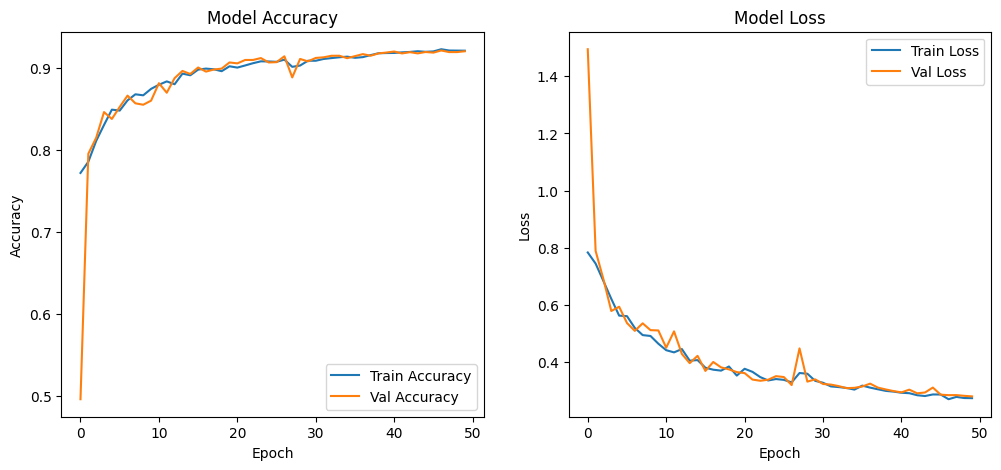

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step


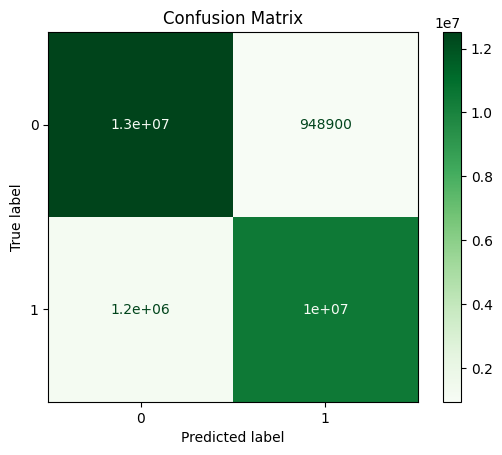

 Classification Report
                 precision    recall  f1-score   support

     Background       0.91      0.93      0.92  13461838
Tampered Region       0.92      0.90      0.91  11626162

       accuracy                           0.92  25088000
      macro avg       0.92      0.91      0.92  25088000
   weighted avg       0.92      0.92      0.92  25088000



In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
from sklearn.model_selection import train_test_split

train_pairs, test_val_pairs = train_test_split(pairs, test_size=0.3, random_state=42, shuffle=True)
val_pairs, test_pairs = train_test_split(test_val_pairs, test_size=1/3, random_state=42, shuffle=True)
train_gen = CMFDGenerator(train_pairs, batch_size=BATCH_SIZE)
val_gen   = CMFDGenerator(val_pairs, batch_size=BATCH_SIZE, shuffle=False)
test_gen  = CMFDGenerator(test_pairs, batch_size=BATCH_SIZE, shuffle=False)


y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = []
for i in range(len(test_gen)):
    _, mask_batch = test_gen[i]
    y_true.append(mask_batch.flatten())

y_true = np.concatenate(y_true)


cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot(cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

print(" Classification Report")
print(classification_report(y_true, y_pred_classes,
                            target_names=['Background', 'Tampered Region']))

In [34]:
from skimage import measure

def highlight_tampered_region_outline(input_img, pred_mask, threshold=0.5, color=(255,0,0), thickness=0.2, dotted=True):
    img = input_img.copy()
    if pred_mask.ndim == 3:
        pred_mask = pred_mask[:,:,0]
    mask = (cv2.resize(pred_mask, (img.shape[1], img.shape[0])) >= threshold).astype(np.uint8)
    contours = measure.find_contours(mask, 0.5)

    for cnt in contours:
        poly = np.round(cnt).astype(np.int32)[:, ::-1]
        for i in range(len(poly)-1):
            p1, p2 = tuple(poly[i]), tuple(poly[i+1])
            if dotted:
                dist = int(np.hypot(p2[0]-p1[0], p2[1]-p1[1]))
                for j in range(0, dist, 6):
                    x = int(p1[0] + j*(p2[0]-p1[0])/dist)
                    y = int(p1[1] + j*(p2[1]-p1[1])/dist)
                    cv2.circle(img, (x,y), thickness, color, -1)
            else:
                cv2.line(img, p1, p2, color, thickness)
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


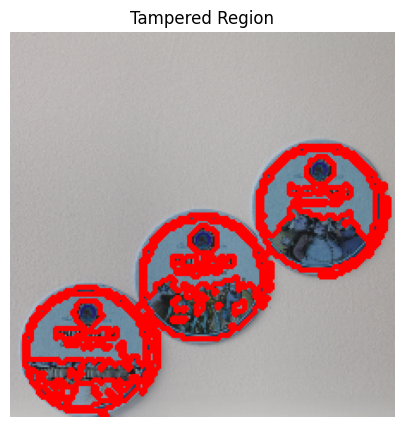

In [52]:
X_val_batch, y_val_batch = val_gen[np.random.randint(0, len(val_gen))]

idx = np.random.randint(0, len(X_val_batch))
test_img = (X_val_batch[idx]*255).astype(np.uint8)
pred_mask = model.predict(np.expand_dims(X_val_batch[idx], 0))[0]

outlined = highlight_tampered_region_outline(test_img, pred_mask,
                                             threshold=0.5, color=(255,0,0),
                                             thickness=1, dotted=True)

plt.figure(figsize=(8,5))
plt.imshow(outlined)
plt.title("Tampered Region")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


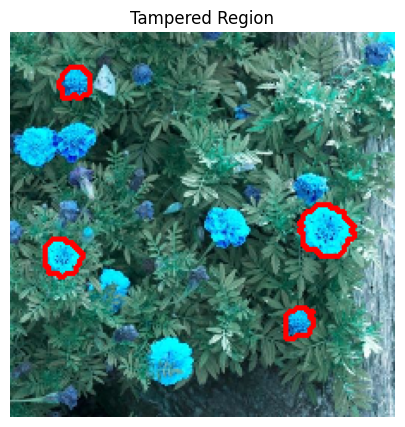

In [53]:
X_val_batch, y_val_batch = val_gen[np.random.randint(0, len(val_gen))]

idx = np.random.randint(0, len(X_val_batch))
test_img = (X_val_batch[idx]*255).astype(np.uint8)
pred_mask = model.predict(np.expand_dims(X_val_batch[idx], 0))[0]

outlined = highlight_tampered_region_outline(test_img, pred_mask,
                                             threshold=0.2, color=(255,0,0),
                                             thickness=1, dotted=True)

plt.figure(figsize=(8,5))
plt.imshow(outlined)
plt.title("Tampered Region")
plt.axis('off')
plt.show()